# Sampling Factors: Pupil to PSF Plane and Scaling for PSF Analysis

## Overview

How to set up the sampling factors for various tasks is not necessarily very clear, as the values also have physical significance. This is particularly evident when we "focus" and take the sample from "pupil space" to "Point Spread Function (PSF) space" or, in physical terms, from the Aperture Plane to the Image Plane.

For example, too large a sampling on the Image Plane (or Point Spread Function (PSF) plane) may result in aliasing. Or A combination of inadequate number of samples but a small sample size will result in the entire PSF is not covered properly. Therefore a careful selection of sampling factors is needed. This becomes particularly important when we want to do a proper accounting of the energy, in order to ensure a radiometrically correct modelling.

## Setting the Scene

To illustrate the intricacies of setting up the PSF or Image Plane Sample Distance and Sample Size, we will have to set up an aperture and initialise a Wavefront. In the next section, we will focus the Wavefront to the PSF or Image Plane.

We start with the opticks package import and initialising units support.

In [15]:
# If opticks import fails, try to locate the module
# This can happen building the docs
import os

try:
    import opticks
except ModuleNotFoundError:
    os.chdir(os.path.join("..", ".."))
    os.getcwd()

In [16]:
import numpy as np

from opticks import u, Q_, P

from astropy.visualization import quantity_support

quantity_support()

%matplotlib inline

from matplotlib import pyplot as plt

import warnings

warnings.filterwarnings("always")

We set up a configuration similar to the one given in [`prysm` examples](https://prysm.readthedocs.io/en/stable/how-tos/Radiometrically-Correct-Modeling.html), but in `opticks` class structure.

We start with a simple `Optics` class. For this example, we assume no optical aberrations.

In [17]:
import numpy as np

from opticks.imager_model.optics import Aperture, Optics

# optics set up
yaml_text = """
name: PTest
focal_length: 2000 mm
aperture_diameter: 500 mm
image_diam_on_focal_plane: 50 mm   # not used"""

optics = Optics.from_yaml_text(yaml_text)

pup_samples = 256

aperture = Aperture.circle_aperture(optics.params.aperture_diameter, pup_samples)

grid = aperture.grid

# set the aperture
optics.set_aperture_model(aperture)

We then initialise and add a Wavefront with the reference wavelength of 500 nm.

In [18]:
# ref wavelength
ref_wvl = 500 * u.nm

print(f"reference wavelength: {ref_wvl}")

# Generate and add the pupil function
optics.add_pupil_func(ref_wvl, None)

reference wavelength: 500.0 nm


## Detour: The Concept of "Q Factor"

The Q Factor is Sampling Frequency divided by the Spatial Cut-off Frequency:

$$ Q = \frac{\lambda \times F_\#}{\text{pix pitch}} $$

where $\lambda$ is the wavelength.

Note that the Sampling Frequency (in pix/mm) is half the Nyquist Limit (in lp/mm), as a Nyquist Limit of 50 lp/mm implies a Sampling Frequency 100 pix/mm, where a line pair can be compressed to two pixels as a maximum.

 A high Q Factor implies a small pixel size and better sampling of the optical resolution. To extract the full range of optical resolution via the detector, the Nyquist limit and and the spatial cut-off should be equal, implying a Q of 2. Q larger than 2 would mean the pixel sizes are too small and we are essentially oversampling the Image Plane but without extracting extra information. A Q of 1 would mean that the Nyquist Limit is half the spatial cut-off frequency.

 On the other hand, a low Q means the detector cannot directly sample the high frequency information (between Nyquist Limit and the Spatial Cut-off Frequency), even though the optics can resolve it. This will cause aliasing in this frequency range.

 In reality, the optical resolution is not equal to the system resolution, as motion blur, jitter and drift reduce the resolution or, in a sense, the information content, on the Image Plane. With less information to resolve, a Q of around 1 is deemed a good target for the detector resolution. 


## Focussing: From the Pupil to the PSF Plane

Focussing takes us from the Pupil Plane to the PSF or Image Plane, essentially covering a focussing distance of (effective) focal length. As we use a sampling of the aperture, this sampling should also be carried to the PSF Plane.

The `psf` uses `focus_fixed_sampling` under the hood, which requires us to prescribe the PSF plane sample distance and sample size (i.e., the number of samples or grid size).

This can be thought of as a detector with pixels on the Image Plane. If the sample size (or pixel size) is too small, then the sampling is finer than the optical resolution ($Q>2$ in the discussion above). On the other hand, the larger the sample (or pixel) size, the smaller (or earlier) is the Nyquist cut-off frequency. This can result in aliasing and generally misleading results. 

For our case, the Q Factor can be rewritten as:

$$ Q = \frac{\lambda \times F_\#}{\text{PSF sample distance}} $$

and therefore the PSF sample distance is 

$$ \text{PSF sample distance} = \frac{\lambda \times F_\#}{Q} $$

Setting $Q = 2$, the largest PSF sample distance that still uses all the optical resolution should be:

$$ \text{PSF sample distance @ Q=2} = \frac{\lambda \times F_\#}{2} $$

In [19]:
# Q factor
Q = 2

# sample distance on the PSF plane
psf_dx = ref_wvl.to(u.um) * optics.f_number / Q

# radius of the Airy Disk
airy_radius = 1.22 * ref_wvl.to(u.um) * optics.f_number

The PSF Plane should be large enough to cover the entire PSF shape, including the extended "tail". Its size is determined by the number of samples and sample distance on the PSF Plane.

In [20]:
from prysm._richdata import RichData

# number of samples in the PSF plane
psf_samples = pup_samples * Q

# Generate the PSF (monochromatic)
psf: RichData = optics.psf(ref_wvl, psf_dx, psf_samples=psf_samples)

print(f"Q factor: {Q}")
print(f"PSF sample distance: {psf.dx:.5}")
# print(f"psf wavelength : {psf.wavelength.to(u.nm):~P}")
print(f"PSF plane size : {len(psf.data) * psf.dx:.5} ({len(psf.data)} samples)")

Q factor: 2
PSF sample distance: 1.0 um
PSF plane size : 512.0 um (512 samples)


## Scaling the PSF for Advanced Analysis

### Unity Sum: Preserving the Radiometry

Many applications require the proper accounting of the radiometry, or the input energy. As explained in the [prysm example](https://prysm.readthedocs.io/en/stable/how-tos/Radiometrically-Correct-Modeling.html), the aperture can be scaled to ensure a PSF sum of 1.0.

For this, we will scale the aperture and start a new `Optics` object. Then we have to regenerate the Pupil Function and recompute the PSF. We will keep all the other scaling parameters constant.

In [21]:
# init new Optics object
optics_psf_unity_sum = Optics.from_yaml_text(yaml_text)

# Scale the aperture for a PSF sum of 1.0
aperture_unity_sum = aperture.scale_for_norm_sum_psf()

# set the optics aperture
optics_psf_unity_sum.set_aperture_model(aperture_unity_sum)

# add the pupil function
optics_psf_unity_sum.add_pupil_func(ref_wvl, None)

# compute the PSF
psf_unity_sum: RichData = optics_psf_unity_sum.psf(
    ref_wvl, psf_dx, psf_samples=psf_samples
)

print(f"Initial PSF (sum and max) : {psf.data.sum(), psf.data.max()}")
print(
    f"Unity sum PSF (sum and max) : {psf_unity_sum.data.sum(), psf_unity_sum.data.max()}"
)

Initial PSF (sum and max) : (51431.00000000001, 10090.437931060791)
Unity sum PSF (sum and max) : (0.9999999999999996, 0.1961936950683591)


(<Figure size 640x480 with 2 Axes>, <Axes: xlabel='um', ylabel='um'>)

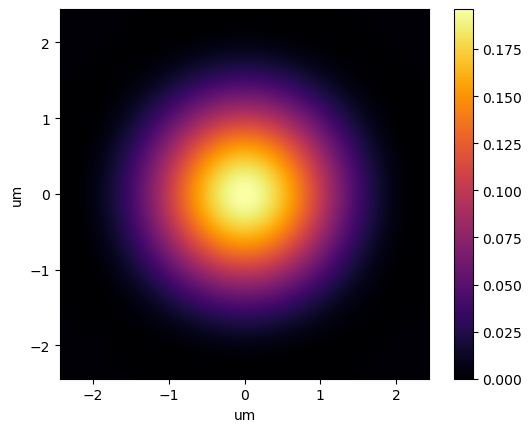

In [22]:
# image limits
xlim = airy_radius * 1

# plot2d has fixed units corresponding to that of dx
# PSF plane definition has units of microns
psf_unity_sum.plot2d(xlim=(-xlim, xlim), log=False, axis_labels=(xlim.unit, xlim.unit))

### Unity Max: Normalising the PSF Peak

The other alternative is to normalise the PSF peak to 1. The methodology is similar: the amplitudes representing the aperture are scaled. But the scaling parameters are different.

In [23]:
# init new Optics object
optics_psf_unity_peak = Optics.from_yaml_text(yaml_text)

# scaling for padding
Q_pad = 1

aperture_unity_peak = aperture.scale_for_norm_peak_psf(Q, Q_pad)

# set the optics aperture
optics_psf_unity_peak.set_aperture_model(aperture_unity_peak)

# add the pupil function
optics_psf_unity_peak.add_pupil_func(ref_wvl, None)

# compute the PSF
psf_unity_peak: RichData = optics_psf_unity_peak.psf(
    ref_wvl, psf_dx, psf_samples=psf_samples
)

print(f"Initial PSF (sum and max) : {psf.data.sum(), psf.data.max()}")
print(
    f"Unity peak PSF (sum and max) : {psf_unity_peak.data.sum(), psf_unity_peak.data.max()}"
)

Initial PSF (sum and max) : (51431.00000000001, 10090.437931060791)
Unity peak PSF (sum and max) : (5.097003752600583, 1.0000000000000044)


(<Figure size 640x480 with 2 Axes>, <Axes: xlabel='um', ylabel='um'>)

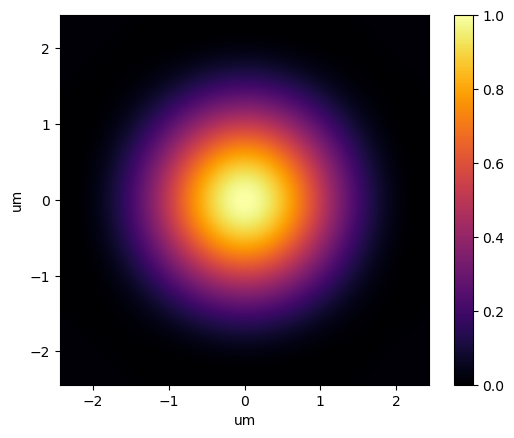

In [24]:
# image limits
xlim = airy_radius * 1

# plot2d has fixed units corresponding to that of dx
# PSF plane definition has units of microns
psf_unity_peak.plot2d(xlim=(-xlim, xlim), log=False, axis_labels=(xlim.unit, xlim.unit))